In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import classification_report
from pylab import rcParams
from sklearn.preprocessing import scale 

%matplotlib inline
plt.style.use('seaborn-white')

In [59]:
import json
with open("the_last_final_data_10min.json", 'r', encoding='UTF-8') as f:
    data = json.load(f)

In [60]:
NEW_COL = ['name', 'code', 'time', 'price', 'time_1', 'price_1', 'price_dif_1',
       'sell_1', 'buy_1', 'volume_1', 'variation_1', 'post_num_1',
       'unique_id_1', 'click_1', 'like_1', 'dislike_1', 'time_2', 'price_2',
       'price_dif_2', 'sell_2', 'buy_2', 'volume_2', 'variation_2',
       'post_num_2', 'unique_id_2', 'click_2', 'like_2', 'dislike_2', 'time_3',
       'price_3', 'price_dif_3', 'sell_3', 'buy_3', 'volume_3', 'variation_3',
       'post_num_3', 'unique_id_3', 'click_3', 'like_3', 'dislike_3',
       'mkt_cap', 'kospi', 'kosdaq', 'trash', 'yesterday_closing_price',
       'is_maximum', 'is_minimum', 'price_volatility', 'price_trend',
       'average_price_volatility', 'sell_minus_buy_1', 'sell_minus_buy_2',
       'sell_minus_buy_3', 'is_price_gap_stable', 'price_gap_volatility',
       'is_like_higher', 'volume_trend', 'post_num_trend', 'unique_id_trend',
       'click_trend', 'price_increase', 'did_price_increase', 'did_price_033',
       'did_price_100', 'did_price_150', 'kospi_ind', 'kosdaq_ind',
       'time_slot', 'ko_inter', 'early_mor', 'morning', 'lunch', 'afternoon',
       'late', 'mkt_change', 'alpha', 'per_now', 'did_opening_price_increase']

In [61]:
df = pd.DataFrame(data, columns = NEW_COL)
df = df.dropna(axis=0, how='any')
df = df[df.did_opening_price_increase == 1]

In [62]:
time_filter = (df['time'].str.startswith("2018-02-21")) | \
              (df['time'].str.startswith("2018-02-22")) | \
              (df['time'].str.startswith("2018-02-23")) | \
              (df['time'].str.startswith("2018-02-26")) 
        
train_df = df[time_filter].reset_index(drop = True)
test_df = df[~time_filter].reset_index(drop = True)

In [63]:
COL_DROP = ['name', 'code', 'time', 'price', 'time_1', 'time_2', 'time_3',
            'did_price_increase', 'did_price_033', 'did_price_100', 
            'did_price_150', 'price_increase', 'did_opening_price_increase',]
X = df.drop(COL_DROP, axis = 1)
y_inc = df['price_increase']
y_0 = df['did_price_increase']
y_33 = df['did_price_033']
y_100 = df['did_price_100']
y_150 = df['did_price_150']
X_train = train_df.drop(COL_DROP, axis = 1)
X_test = test_df.drop(COL_DROP, axis = 1)
y_train_in = train_df['price_increase']
y_train_0 = train_df['did_price_increase']
y_train_33 = train_df['did_price_033']
y_train_100 = train_df['did_price_100']
y_train_150 = train_df['did_price_150']
y_test_in = test_df['price_increase']
y_test_0 = test_df['did_price_increase']
y_test_33 = test_df['did_price_033']
y_test_100 = test_df['did_price_100']
y_test_150 = test_df['did_price_150']

In [41]:
def find_best_pca(num):
    pca = PCA()
    X_reduced_train = pca.fit_transform(scale(X_train))
    n = len(X_reduced_train)
    kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)
    mse = []
    regr = LogisticRegression()
    score = -1*cross_val_score(regr, np.ones((n,1)), y_train_0, cv=kf_10, scoring='neg_mean_squared_error').mean()    
    mse.append(score)
    for i in np.arange(1, num):
        score = abs(cross_val_score(regr, X_reduced_train[:,:i], y_train_0, cv=kf_10, scoring='neg_mean_squared_error')).mean()
        mse.append(score)
    
    return mse.index(min(mse))        

In [46]:
def get_best_mean(num):
    
    best_pca = find_best_pca(num)
    pca = PCA()
    X_reduced_train = pca.fit_transform(scale(X_train))
    X_reduced_test = pca.transform(scale(X_test))[:,:best_pca]
    reg_log = LogisticRegression()
    model = reg_log.fit(X_reduced_train[:,:best_pca], y_train_0)
    y_pred = reg_log.predict(X_reduced_test)
    y_port = y_test_in[y_pred == 1]
    
    return best_pca, y_port.mean()    

In [ ]:
get_best_mean(66)

In [48]:
y_test_in.mean()

-0.04998352406155759

implementation

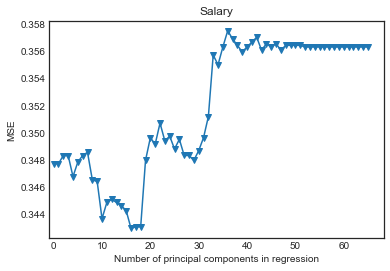

In [23]:
pca3 = PCA()
X_reduced_train = pca3.fit_transform(scale(X_train))
n = len(X_reduced_train)

kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)

mse = []
regr = LogisticRegression()

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train_0, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 66):
    score = abs(cross_val_score(regr, X_reduced_train[:,:i], y_train_0, cv=kf_10, scoring='neg_mean_squared_error')).mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1); #five is enough

In [50]:
pca3 = PCA()
X_reduced_train = pca3.fit_transform(scale(X_train))
n = len(X_reduced_train)

X_reduced_test = pca3.transform(scale(X_test))[:,:16]

# Train regression model on training data 
reg_log = LogisticRegression()
model = reg_log.fit(X_reduced_train[:,:16], y_train_0)

# Prediction with test data
y_pred_0 = reg_log.predict(X_reduced_test)
mean_squared_error(y_test_0, y_pred_0)

0.36081193040596521

In [52]:
print(classification_report(compare_0["test_0"], compare_0["pred_0"]))

             precision    recall  f1-score   support

          0       0.64      0.98      0.77      1527
          1       0.60      0.05      0.10       887

avg / total       0.63      0.64      0.53      2414



In [51]:
compare_0 = pd.concat([pd.DataFrame(y_pred_0), y_test_0.reset_index(drop = True)], axis = 1)
compare_0.columns = ["pred_0", "test_0"]
correct = (compare_0["pred_0"] == compare_0["test_0"])
correct.value_counts()

True     1543
False     871
dtype: int64

In [53]:
y_port = y_test_in[y_pred_0 == 1]

In [54]:
y_test_in.mean()

-0.04998352406155759

In [55]:
y_port.mean()

0.021052752311538515

PLS

In [64]:
def find_pls(num):
    
    n = len(X_train)
    kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)
    mse = []
    for i in np.arange(1, 66):
        pls = PLSRegression(n_components=i)
        score = cross_val_score(pls, scale(X_train), y_train_0, \
                                cv=kf_10, scoring='neg_mean_squared_error').mean()
        mse.append(-score)
        
    return mse.index(min(mse))
    

In [ ]:
n_pls = find_pls(66)
pls = PLSRegression(n_components=52)
pls.fit(scale(X_train), y_train_0)
y_pred_pls = pls.predict(scale(X_test))
y_pred_pls = np.reshape(y_pred_pls, y_pred_pls.shape[0])
y_port = y_test_in[y_pred_pls >= .5]
y_port.mean()

implementation

In [ ]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 66):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train_0, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 66), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1) 